#Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#Image Processing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to be between 0 and 1
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,   # Zoom range
    horizontal_flip=True  # Randomly flip images horizontally
)

In [ ]:
# Defining image and batch size
img_size = (128, 128)
batch_size = 32

In [ ]:
# Implementing the datagen class instance created earlier on our images
data_generator = datagen.flow_from_directory('/content/drive/MyDrive/4th',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  # Set to 'categorical' for multiclass classification
)

Found 2080 images belonging to 3 classes.


In [ ]:
#Using the concurrent.futures module to launch parallel tasks of adding images and labels to a list
import concurrent.futures

# Defining a function to process a batch
def process_batch(batch):
    batch_images, batch_labels = data_generator.next()
    return batch_images, batch_labels

num_workers = 8

images = []
labels = []

# Using ThreadPoolExecutor for parallel processing
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Submitting tasks for each batch
    futures = [executor.submit(process_batch, None) for _ in range(len(data_generator))]

    # Retrieving results as they become available
    for future in concurrent.futures.as_completed(futures):
        batch_images, batch_labels = future.result()
        images.extend(batch_images)
        labels.extend(batch_labels)

In [ ]:
labels[0]

array([0., 0., 1.], dtype=float32)

In [ ]:
print(f'Number of images: {len(images)} \nNumber of labels: {len(labels)}')

Number of images: 2080 
Number of labels: 2080


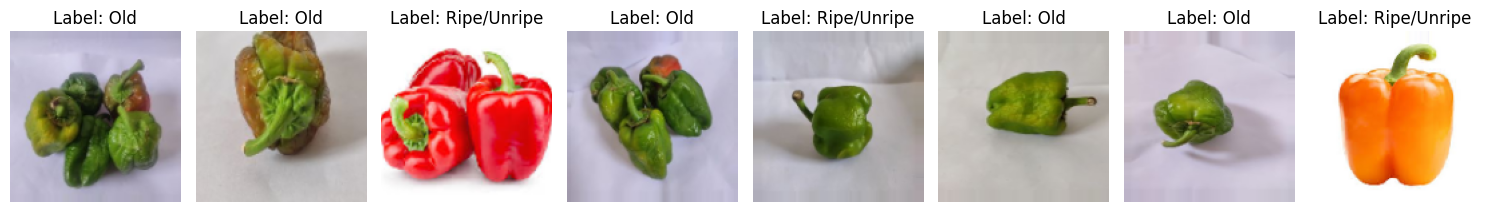

In [ ]:
# Randomly plotting our images
import random

# Sample size for plotting
sample_size = 8

# Randomly selecting a few samples from your dataset
selected_samples = random.sample(range(len(images)), sample_size)

# Creating a subplot with rows and columns
rows = 1
cols = sample_size

# Seting up our subplot
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
arr1 = np.array([1,0,0])
arr2=np.array([0,1,0])
arr3=np.array([0,0,1])

# Ploting selected images in the subplot
for i, ax in zip(selected_samples, axes):
    image = images[i]
    label = labels[i]
    # Assuming images are NumPy arrays
    ax.imshow(image)
    if np.array_equal(label, arr1):
      ax.set_title(f"Label: Dried")
    elif np.array_equal(label, arr2):
      ax.set_title(f"Label: Old")
    else:
      ax.set_title(f"Label: Ripe/Unripe")
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

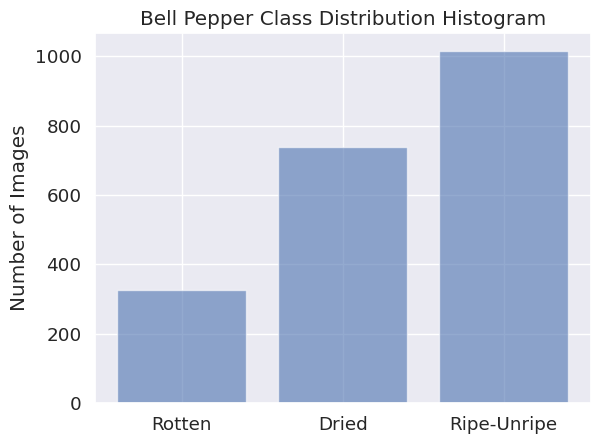

In [ ]:
import matplotlib.pyplot as plt

# Calculate the class distribution from the labels
class_distribution = [np.argmax(label) for label in labels]

# Create a histogram
plt.hist(class_distribution, bins=range(4), rwidth=0.8, alpha=0.6, align='left')

# Set labels and title
plt.ylabel('Number of Images')
plt.title('Bell Pepper Class Distribution Histogram')

# Define class labels
class_labels = ['Rotten', 'Dried', 'Ripe-Unripe']

# Set x-tick labels
plt.xticks(range(3), class_labels)

# Show the histogram
plt.show()

In [ ]:
labels[0]

array([0., 0., 1.], dtype=float32)

#Splitting Training Sets and Validation Sets

In [ ]:
# Dividing dataset to train test and validaiton sets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Saving images to variable X and corresponding labels to variable y
X = images
y = labels

# Shuffling the data
X, y_encoded = shuffle(X, y, random_state=42)

# Split the data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5)

In [ ]:
# Converting our data into numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

# Converting test datasets to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

#Training Model

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the pre-trained InceptionV3 model with weights trained on ImageNet data
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a Global Average Pooling layer to the base model
x = GlobalAveragePooling2D()(base_model.output)

# Add fully connected layers on top of InceptionV3
x = Dense(4096, activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(1000, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

# Output layer with 38 units for your specific classification task
output = Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the InceptionV3 pretrained model with your dataset
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
52/52 [==============================] - 11s 90ms/step - loss: 0.7131 - accuracy: 0.8564 - val_loss: 3.7193 - val_accuracy: 0.8462
Epoch 2/30
52/52 [==============================] - 2s 41ms/step - loss: 0.2202 - accuracy: 0.9309 - val_loss: 0.4942 - val_accuracy: 0.8942
Epoch 3/30
52/52 [==============================] - 2s 41ms/step - loss: 0.1859 - accuracy: 0.9375 - val_loss: 0.2056 - val_accuracy: 0.9375
Epoch 4/30
52/52 [==============================] - 2s 43ms/step - loss: 0.0977 - accuracy: 0.9639 - val_loss: 0.1822 - val_accuracy: 0.9615
Epoch 5/30
52/52 [==============================] - 2s 41ms/step - loss: 0.1147 - accuracy: 0.9609 - val_loss: 0.2402 - val_accuracy: 0.9423
Epoch 6/30
52/52 [==============================] - 2s 42ms/step - loss: 0.1214 - accuracy: 0.9609 - val_loss: 0.1629 - val_accuracy: 0.9519
Epoch 7/30
52/52 [==============================] - 2s 46ms/step - loss: 0.0981 - accuracy: 0.9645 - val_loss: 0.1644 - val_accuracy: 0.9567
Epoch 8/30
5

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the AlexNet pretrained model with my dataset
classifier = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
52/52 [==============================] - 10s 90ms/step - loss: 0.0981 - accuracy: 0.9694 - val_loss: 0.2251 - val_accuracy: 0.9327
Epoch 2/30
52/52 [==============================] - 2s 41ms/step - loss: 0.0655 - accuracy: 0.9784 - val_loss: 0.1730 - val_accuracy: 0.9663
Epoch 3/30
52/52 [==============================] - 2s 41ms/step - loss: 0.0536 - accuracy: 0.9814 - val_loss: 0.3319 - val_accuracy: 0.9663
Epoch 4/30
52/52 [==============================] - 2s 38ms/step - loss: 0.0755 - accuracy: 0.9754 - val_loss: 0.3690 - val_accuracy: 0.9327
Epoch 5/30
52/52 [==============================] - 2s 37ms/step - loss: 0.0438 - accuracy: 0.9832 - val_loss: 0.3929 - val_accuracy: 0.9471
Epoch 6/30
52/52 [==============================] - 2s 38ms/step - loss: 0.0400 - accuracy: 0.9862 - val_loss: 0.3289 - val_accuracy: 0.9471
Epoch 7/30
52/52 [==============================] - 2s 44ms/step - loss: 0.0390 - accuracy: 0.9856 - val_loss: 0.3474 - val_accuracy: 0.9279
Epoch 8/30
5

#Training Validation

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_603 (Conv2D)         (None, 63, 63, 32)           864       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_606 (B  (None, 63, 63, 32)           96        ['conv2d_603[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_564 (Activation  (None, 63, 63, 32)           0         ['batch_normalization_60

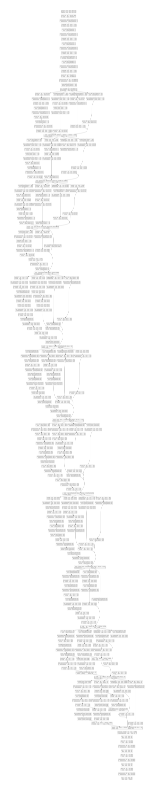

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Displaying the model architecture summary
model.summary()

# Saving the model architecture plot to a file
plot_model(model, to_file='alexnetplot.png', show_shapes=True, show_layer_names=True)

# Displaying the personalized model architecture plot within the script
img = mpimg.imread('alexnetplot.png')

# Create a figure and axis for custom annotations
fig, ax = plt.subplots(figsize=(10, 10))

# Display the image
ax.imshow(img)
ax.axis('off')

# Add custom annotations or styling here if needed
# For example, you can add text labels or arrows to highlight specific parts of the plot.

# Save the personalized visualization to a file (optional)
# plt.savefig('alexnet.png', bbox_inches='tight')

# Show the personalized visualization
plt.show()


In [ ]:
eval_result = model.evaluate(X_test, y_test)

# The evaluate method returns a list containing the loss and metrics values
# Assuming accuracy is one of the metrics, you can access it as follows:
accuracy = eval_result[1]

print(f'Test Accuracy: {accuracy * 100:.2f}%')

7/7 [==============================] - 0s 40ms/step - loss: 0.1984 - accuracy: 0.9615
Test Accuracy: 96.15%


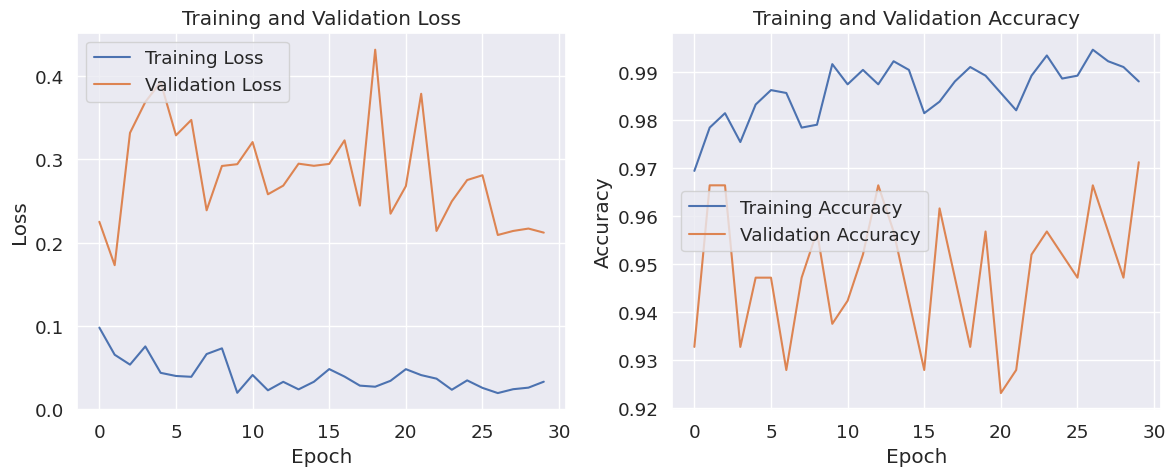

In [ ]:
# Model Performance during training

# Training and validation loss plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(classifier.history['loss'], label='Training Loss')
plt.plot(classifier.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy plots
plt.subplot(1, 2, 2)
plt.plot(classifier.history['accuracy'], label='Training Accuracy')
plt.plot(classifier.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

7/7 [==============================] - 2s 45ms/step


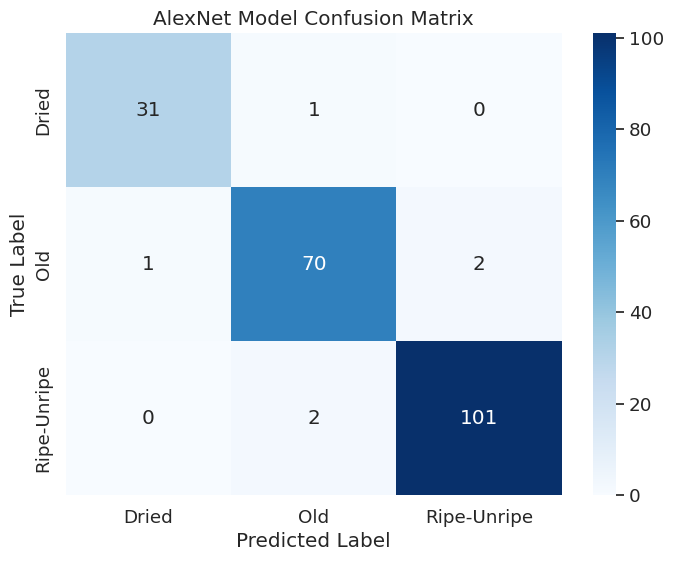

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have already trained your model and have predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(np.argmax(y_val, axis=1), y_pred_classes)

# Define the class names (change these to match your classes)
class_names = ['Dried', 'Old', 'Ripe-Unripe']

# Create a figure and axis for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('AlexNet Model Confusion Matrix')

# Show the plot
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming X_test and y_test are your test set and labels
# X_test = ...
# y_test = ...

# Make predictions
batch_size = 4  # or any other value
y_pred_batches = []

for i in range(0, len(X_test), batch_size):
    batch_predictions = model.predict(X_test[i:i+batch_size])
    y_pred_batches.append(batch_predictions)

y_pred = np.concatenate(y_pred_batches, axis=0)
# Convert predictions to binary indicator matrix
threshold = 0.5  # You can adjust the threshold based on your needs
predicted_classes = (y_pred > threshold).astype(int)

# Ensure y_test is in the correct format for multilabel classification
# y_test = [[1, 0, 1], [0, 1, 0], [1, 1, 1], ...]

# Compute accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

1/1 [==============================] - 0s 24ms/step
Accuracy: 96.15%


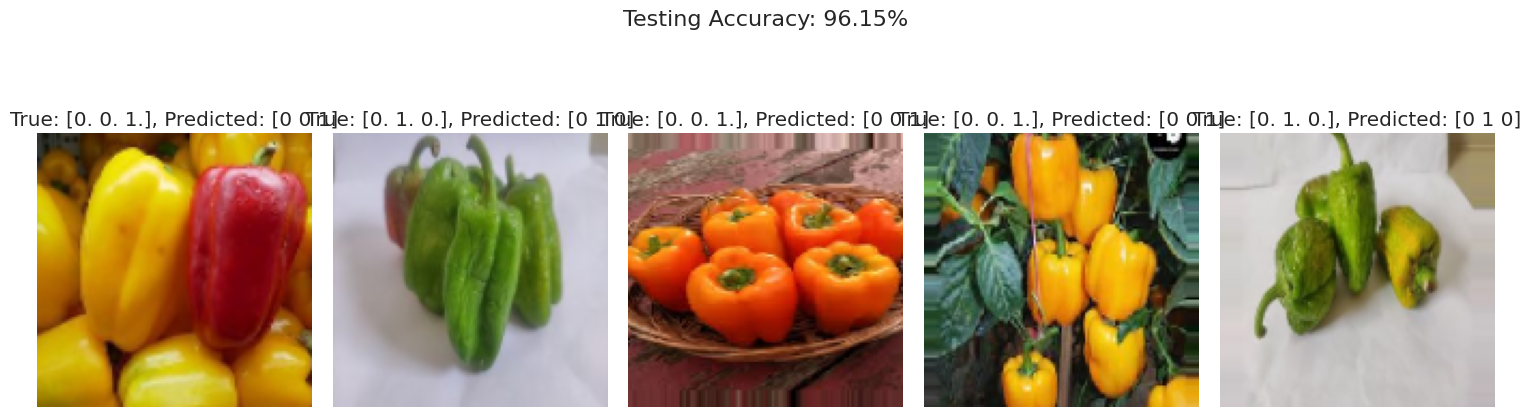

In [ ]:
# We will need to convert the probability values into binary predictions. First we set a threshold value to divide the probability values into corresponding classes
threshold = 0.5
binary_predictions = (y_pred > threshold).astype(int)

# Calculating testing accuracy
test_accuracy = np.sum(binary_predictions.squeeze() == y_test) / len(y_test)

# Sample size for plotting
test_size = 5

# Randomly selecting a few samples from the testing set
test_samples = np.random.choice(range(len(X_test)), test_size, replace=False)

# Now we create a subplot with rows and columns
rows = 1
cols = test_size

# Setting up the subplot
fig, axes = plt.subplots(rows, cols, figsize=(15, 5))

# Plotting the selected images with corresponding predictions of our model
for i, ax in zip(test_samples, axes):
    image = X_test[i]
    true_label = y_test[i]
    predicted_label = binary_predictions[i]
    ax.imshow(image)
    ax.set_title(f"True: {true_label}, Predicted: {predicted_label}")
    ax.axis('off')  # Turning off axis labels as it overlaps with our class labels on the plot

#Display testing accuracy on the plot
fig.suptitle(f"Testing Accuracy: {accuracy * 100:.2f}%", fontsize=16)

#Adjusting layout to prevent clipping
plt.tight_layout(rect=[0, 0.1, 1, 0.9])  # Adjust the top margin to make space for the title
plt.show()

#Save Model

In [ ]:
from google.colab import files
model.save("../1-30-2024_75-25_bellpepperVGG16.h5")
file_name = '/1-30-2024_75-25_bellpepperVGG16.h5'

# Provide a download link for the H5 file
files.download(file_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>